- day + animal + sex
- experiment + animal + sex
- comparison top 10 to rest in both


Expectations:
- variation across different experiments and gap lengths
- stronger in female mice
- variation across recording days without pattern
- stronger in first 10 recordings

Sex: nominal chi-squared
Weight: interval/ratio 
Strength: interval/ratio 
Reaction Time: interval/ratio 
Recording Day: nominal
Experiment type: nominal


reaction time non-parametric, strength normally distributed!


H0s:
1: no correlation between weight and strength if normalized -> extra weight does not indicate more muscle mass (no correlation, Pearson test)
2: no relationship between sex and strength (if strength normalized for weight? Maybe with and without normalization?) (independant two paired groups, ind. t-test and ANCOVA with weight as covariable) 
3: no influence of sex on reaction time (independant, Mann–Whitney U Test)
4: no relationship between day of measurement and strength and reaction time (ANOVA (norm, for strength), Friedman (non-para, for reaction time) OR linear mixed model)
5: first 10 recordings do not differ in strength or reaction time
6: experiment type has no influence on strength or reaction time


4th recording day would only help clarify effect of day and age

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare
import re
import seaborn as sns
import os
from itertools import combinations
import inspect
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
input_dir = "Results" # input directory

number = "1" # results to analyze (subfolder name, can be an integer or string)

In [3]:
results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

file_path = os.path.join(results_dir, files[0])
df = pd.read_excel(file_path)

file_path_top_10 = os.path.join(results_dir, files[1])
df_top_10 = pd.read_excel(file_path_top_10)

Strength: W = 0.942, p = 1.15e-05
Reaction Time: W = 0.891, p = 7.41e-09
Log-transformed Reaction Time: p = 5.03e-11
Box-Cox Transformed Reaction Time: W = 0.894, p = 1.07e-08
Optimal λ = 1.426


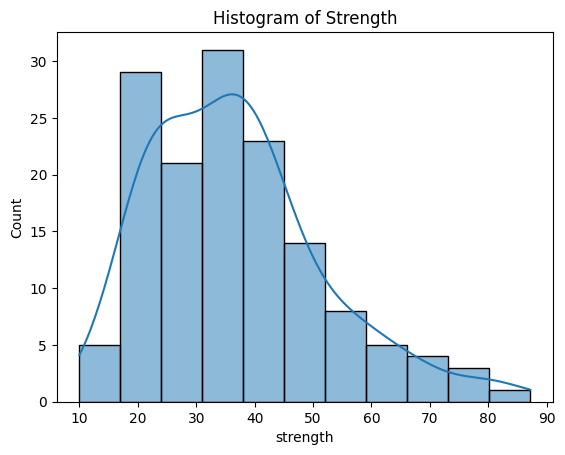

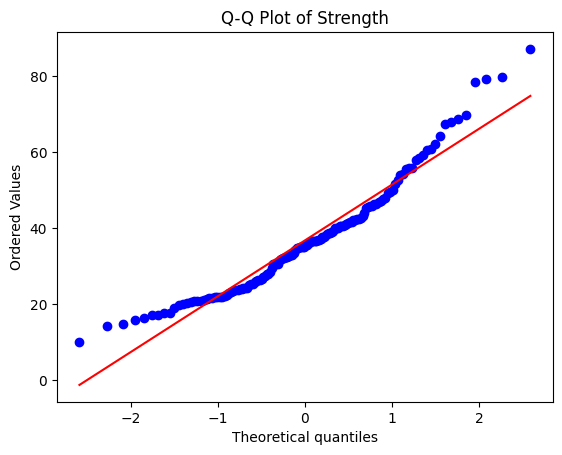

In [4]:
# Shapiro-Wilk test for normality

stat_strength, p_strength = shapiro(df["strength"].dropna())
print(f"Strength: W = {stat_strength:.3f}, p = {p_strength:.3g}")
# ----> normal


# Run Shapiro–Wilk test for reaction time
stat_rt, p_rt = shapiro(df["reactionTime"].dropna())
print(f"Reaction Time: W = {stat_rt:.3f}, p = {p_rt:.3g}")

# Try log fit
df["reactionTime_log"] = np.log(df["reactionTime"])
stat_rt_log, p_rt_log = shapiro(df["reactionTime_log"].dropna())
print(f"Log-transformed Reaction Time: p = {p_rt_log:.3g}")
# ----> nope

reaction_times = df["reactionTime"].dropna()

# Try Box-Cox transform
reaction_time_boxcox, fitted_lambda = boxcox(reaction_times)

# Store transformed values in the DataFrame (optional)
df["reactionTime_boxcox"] = pd.Series(reaction_time_boxcox, index=reaction_times.index)

# Test normality of Box-Cox transformed data
stat_boxcox, p_boxcox = shapiro(reaction_time_boxcox)
print(f"Box-Cox Transformed Reaction Time: W = {stat_boxcox:.3f}, p = {p_boxcox:.3g}")
print(f"Optimal λ = {fitted_lambda:.3f}")
# ----> nope

# -> reaction time non-parametric, strength normally distributed

# plot
sns.histplot(df["strength"].dropna(), kde=True)
plt.title("Histogram of Strength")
plt.show()

# Q-Q Plot
stats.probplot(df["strength"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Strength")
plt.show()

In [5]:
# compare top 10


t_stat, p_val = ttest_ind(df_top_10["strength"].dropna(),
                        df["strength"].dropna(),
                        equal_var=False)  # Welch’s t-test if variances unequal
print(f"T-test for strength: t = {t_stat:.3f}, p = {p_val:.3g}")
# ----> nope


u_stat, p_val = mannwhitneyu(df_top_10["reactionTime"].dropna(),
                            df["reactionTime"].dropna(),
                            alternative='two-sided')
print(f"Mann-Whitney U test for reaction time: U = {u_stat}, p = {p_val:.3g}")
# ----> nope

T-test for strength: t = 1.627, p = 0.107
Mann-Whitney U test for reaction time: U = 4402.5, p = 0.468


In [6]:
""" # 1. No correlation between weight and normalized strength (Pearson correlation) (NEED MORE WEIGHT MEASUREMENTS)


# Assuming 'strength_norm' is strength normalized for weight or similar
weight = df["mass"].dropna()
strength_norm = df["strength"].dropna()

# Align indices in case of missing data
weight_aligned, strength_aligned = weight.align(strength_norm, join='inner')

r, p = pearsonr(weight_aligned, strength_aligned)
print(f"Pearson correlation weight vs normalized strength: r = {r:.3f}, p = {p:.3g}")

print("Weight unique values:", weight_aligned.unique())
print("Strength normalized unique values:", strength_aligned.unique()) """

' # 1. No correlation between weight and normalized strength (Pearson correlation) (NEED MORE WEIGHT MEASUREMENTS)\n\n\n# Assuming \'strength_norm\' is strength normalized for weight or similar\nweight = df["mass"].dropna()\nstrength_norm = df["strength"].dropna()\n\n# Align indices in case of missing data\nweight_aligned, strength_aligned = weight.align(strength_norm, join=\'inner\')\n\nr, p = pearsonr(weight_aligned, strength_aligned)\nprint(f"Pearson correlation weight vs normalized strength: r = {r:.3f}, p = {p:.3g}")\n\nprint("Weight unique values:", weight_aligned.unique())\nprint("Strength normalized unique values:", strength_aligned.unique()) '

In [7]:
# 2. Relationship between sex and strength (independent two-group t-test and ANCOVA with weight as covariate)

# Independent t-test (assumes 'sex' coded as categorical, e.g., 'M', 'F')
group1 = df[df["sex"] == "M"]["strength"].dropna()
group2 = df[df["sex"] == "F"]["strength"].dropna()

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"T-test for strength by sex: t = {t_stat:.3f}, p = {p_val:.3g}")
# --> sample size too small 
""" 
# ANCOVA: strength ~ sex + weight
# Make sure sex is treated as categorical
df['sex'] = df['sex'].astype('category')

model = ols("Q('strength (g⋅kg^(-α))') ~ sex + weight", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANCOVA table:\n", anova_table)
# --> effect of both weight and sex on strength  """

T-test for strength by sex: t = nan, p = nan


C:\Users\Galahad\AppData\Local\Temp\ipykernel_13068\837830791.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(group1, group2, equal_var=False)


' \n# ANCOVA: strength ~ sex + weight\n# Make sure sex is treated as categorical\ndf[\'sex\'] = df[\'sex\'].astype(\'category\')\n\nmodel = ols("Q(\'strength (g⋅kg^(-α))\') ~ sex + weight", data=df).fit()\nanova_table = sm.stats.anova_lm(model, typ=2)\nprint("ANCOVA table:\n", anova_table)\n# --> effect of both weight and sex on strength  '

In [8]:
#3. Influence of sex on reaction time (non-normal data → Mann–Whitney U test)

group1_rt = df[df["sex"] == "M"]["reactionTime"].dropna()
group2_rt = df[df["sex"] == "F"]["reactionTime"].dropna()

u_stat, p_val = mannwhitneyu(group1_rt, group2_rt, alternative='two-sided')
print(f"Mann-Whitney U test for reaction time by sex: U = {u_stat}, p = {p_val:.3g}")
# --> sample size too small 

Mann-Whitney U test for reaction time by sex: U = nan, p = nan


C:\Users\Galahad\AppData\Local\Temp\ipykernel_13068\3497997993.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_val = mannwhitneyu(group1_rt, group2_rt, alternative='two-sided')


In [9]:
# 4. Relationship between day of measurement and strength (normal) and reaction time (non-normal) (NEEDS THIRD RECORDING)


# ANOVA for strength by day

strength_agg = df.groupby(['animal', 'date'])["strength"].mean().reset_index()
strength_agg['date'] = strength_agg['date'].astype('category')

model_strength = ols("Q('strength') ~ date", data=strength_agg).fit()
anova_strength = sm.stats.anova_lm(model_strength, typ=2)
print("ANOVA for strength by date:\n", anova_strength)
# ----> no change of strength across days

# Friedman test for reaction time by day (non-parametric)

# Aggregate reaction time per animal per date (e.g., mean)
reaction_time_agg = df.groupby(['animal', 'date'])['reactionTime'].mean().reset_index()

# Pivot to wide format for Friedman test
reaction_time_wide = reaction_time_agg.pivot(index='animal', columns='date', values='reactionTime').dropna()

# Run Friedman test (needs 3rd recording)
#stat, p_val = friedmanchisquare(*[reaction_time_wide[day] for day in reaction_time_wide.columns])
#print(f"Friedman test for reaction time by date: chi2 = {stat:.3f}, p = {p_val:.3g}")
# ----> needs third recording day to work


#Linear Mixed Model (more advanced, handles repeated measures)

# For strength (normal)
model_lmm_strength = smf.mixedlm("Q('strength') ~ date", df, groups=df["animal"]).fit()
print(model_lmm_strength.summary())

ANOVA for strength by date:
                sum_sq    df         F    PR(>F)
date       421.978390   2.0  1.045528  0.375766
Residual  3027.024317  15.0       NaN       NaN
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('strength')
No. Observations: 144     Method:             REML         
No. Groups:       6       Scale:              64.1704      
Min. group size:  24      Log-Likelihood:     -509.5770    
Max. group size:  24      Converged:          Yes          
Mean group size:  24.0                                     
-----------------------------------------------------------
                  Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         30.524    5.334 5.723 0.000 20.070 40.977
date[T.June26]    11.767    1.635 7.196 0.000  8.562 14.972
date[T.May20]      7.167    1.635 4.383 0.000  3.962 10.372
Group Var        162.658   13.291                         

In [10]:
# 5 Experiment type

model_lmm_strength = smf.mixedlm("Q('strength') ~ experiment", df, groups=df["animal"]).fit()
print(model_lmm_strength.summary())

model_lmm_rt = smf.mixedlm("Q('reactionTime') ~ experiment", df, groups=df["animal"]).fit()
print(model_lmm_rt.summary())
# ----> no effect on strength, some effect on reaction time
# highly significant difference for tone_in_noise
# meaningful difference in reaction time between individuals


print("Strength experiment type effects:")
print(model_lmm_strength.summary())

print("\nReaction Time experiment type effects:")
print(model_lmm_rt.summary())

# You can extract p-values like:
print("\nP-values for experiment effects on strength:")
print(model_lmm_strength.pvalues)

print("\nP-values for experiment effects on reaction time:")
print(model_lmm_rt.pvalues)

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Q('strength')
No. Observations:      144          Method:                  REML         
No. Groups:            6            Scale:                   80.1544      
Min. group size:       24           Log-Likelihood:          -512.4010    
Max. group size:       24           Converged:               Yes          
Mean group size:       24.0                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      38.784    5.608  6.916 0.000  27.792 49.775
experiment[T.gap_depth]         0.465    2.984  0.156 0.876  -5.384  6.314
experiment[T.gap_duration_10]  -1.667    2.984 -0.559 0.576  -7.516  4.182
experiment[T.gap_duration_20]  -2.413    2.9

In [11]:
formula = 'Q("strength") ~ sex'

model = smf.ols(formula=formula, data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("strength")   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     90.25
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           7.16e-17
Time:                        17:24:55   Log-Likelihood:                -557.84
No. Observations:                 144   AIC:                             1120.
Df Residuals:                     142   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      27.5504      1.382     19.934      

# Plotting

In [12]:
def analyze_results(df=df, strength=False, by_date=False, by_sex=True):
    if not by_date:
        if by_sex:
            grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()
        else:
            grouped_df = df.groupby(['experiment'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment'], as_index=False, observed=True)['reactionTime'].mean()
        
    else:
        grouped_df = {}
        unique_dates = df['date'].unique()

        for date in unique_dates: 
            df_date = df[df['date'] == date]
            if by_sex:
                grouped_df[date] = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()
            else:
                grouped_df[date] = df_date.groupby(['experiment'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment'], as_index=False, observed=True)['reactionTime'].mean()

    print(grouped_df)

In [13]:
def plot_results(df=df, strength=False, by_date=False):
    if not by_date:
        # Group by experiment and sex, averaging reactionTime across animals and dates
        grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()

        # Preserve the order of experiments
        experiment_order = df['experiment'].drop_duplicates().tolist()
        grouped_df['experiment'] = pd.Categorical(grouped_df['experiment'], categories=experiment_order, ordered=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=grouped_df,
            x='experiment',
            y='strength' if strength else 'reactionTime',
            hue='sex',
            order=experiment_order,
            errorbar=None
        )

        plt.xticks(rotation=45, ha='right')
        plt.title("Average Strength per Experiment") if strength else plt.title("Average Reaction Time per Experiment")
        plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
        plt.xlabel("Experiment")
        plt.tight_layout()
        plt.show()
        
    else:
        experiment_order = df['experiment'].drop_duplicates().tolist()

        unique_dates = df['date'].unique()

        for date in unique_dates:
            df_date = df[df['date'] == date]

            grouped = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()

            grouped['experiment'] = pd.Categorical(grouped['experiment'], categories=experiment_order, ordered=True)

            plt.figure(figsize=(12, 6))
            sns.barplot(
                data=grouped,
                x='experiment',
                y='strength' if strength else 'reactionTime',
                hue='sex',
                order=experiment_order,
                errorbar=None
            )

            plt.title(f"Average Strength per Experiment - {date}") if strength else plt.title(f"Average Reaction Time per Experiment - {date}")
            plt.xticks(rotation=45, ha='right')
            plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
            plt.xlabel("Experiment")
            plt.tight_layout()
            plt.show()

In [14]:
analyze_results()

         experiment     sex  reactionTime
0       ASR_control  female     11.174444
1       ASR_control    male     10.555556
2         gap_depth  female     10.500000
3         gap_depth    male      9.955556
4   gap_duration_10  female     10.500000
5   gap_duration_10    male     10.463333
6   gap_duration_20  female     10.444444
7   gap_duration_20    male     10.252222
8    gap_duration_4  female     10.722222
9    gap_duration_4    male     10.255556
10  gap_duration_50  female     10.755556
11  gap_duration_50    male     10.311111
12   gap_duration_8  female     10.677778
13   gap_duration_8    male     10.677778
14    tone_in_noise  female      9.766667
15    tone_in_noise    male      9.033333


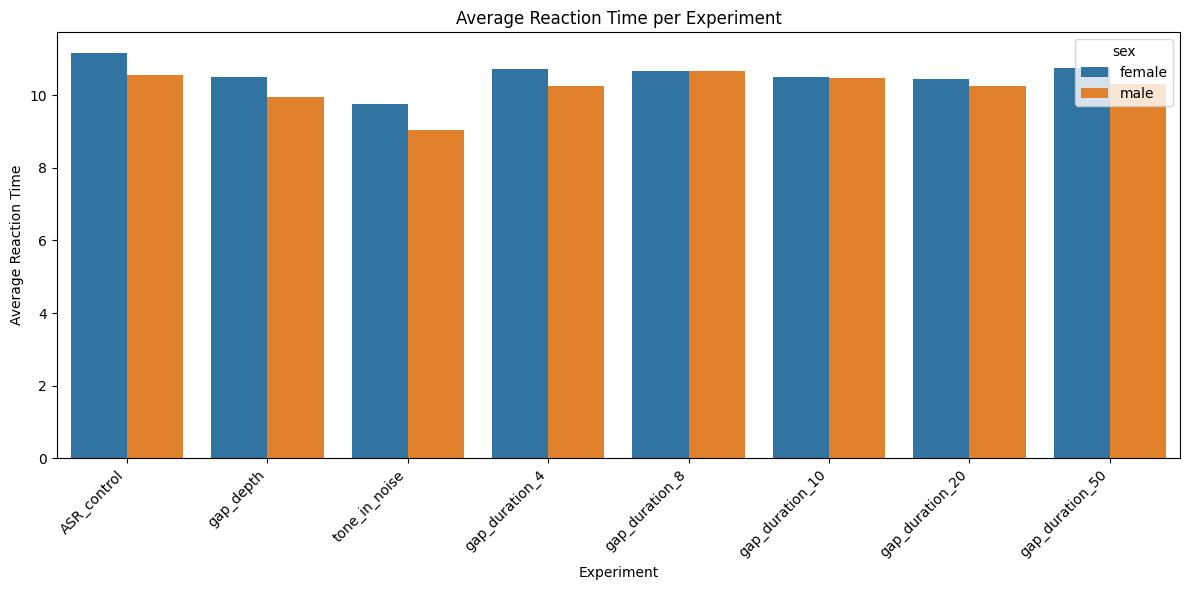

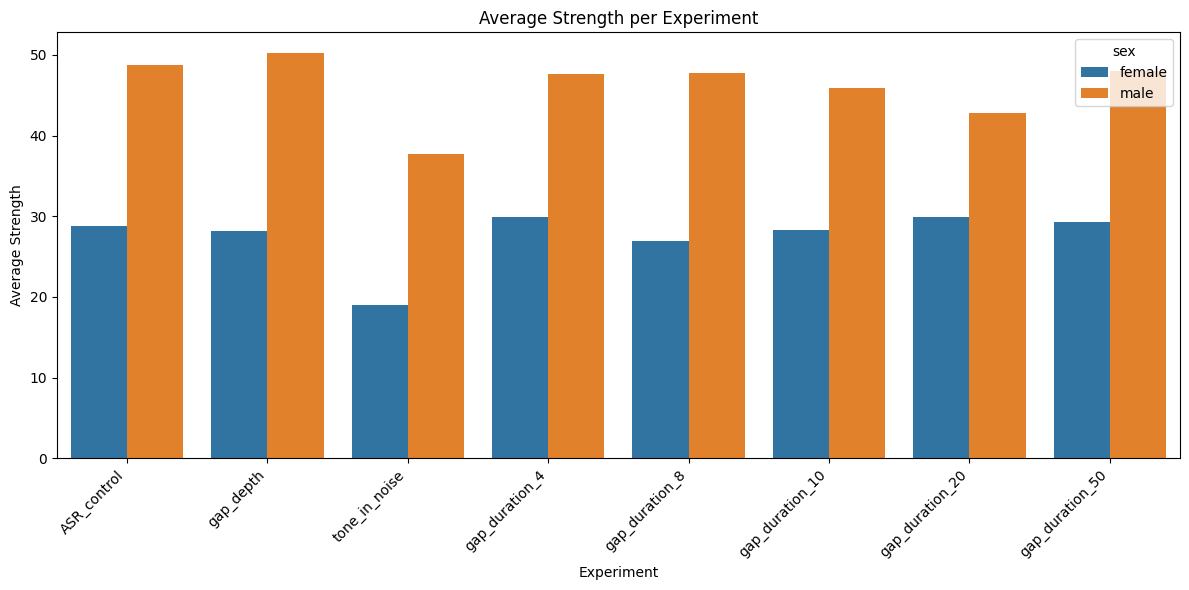

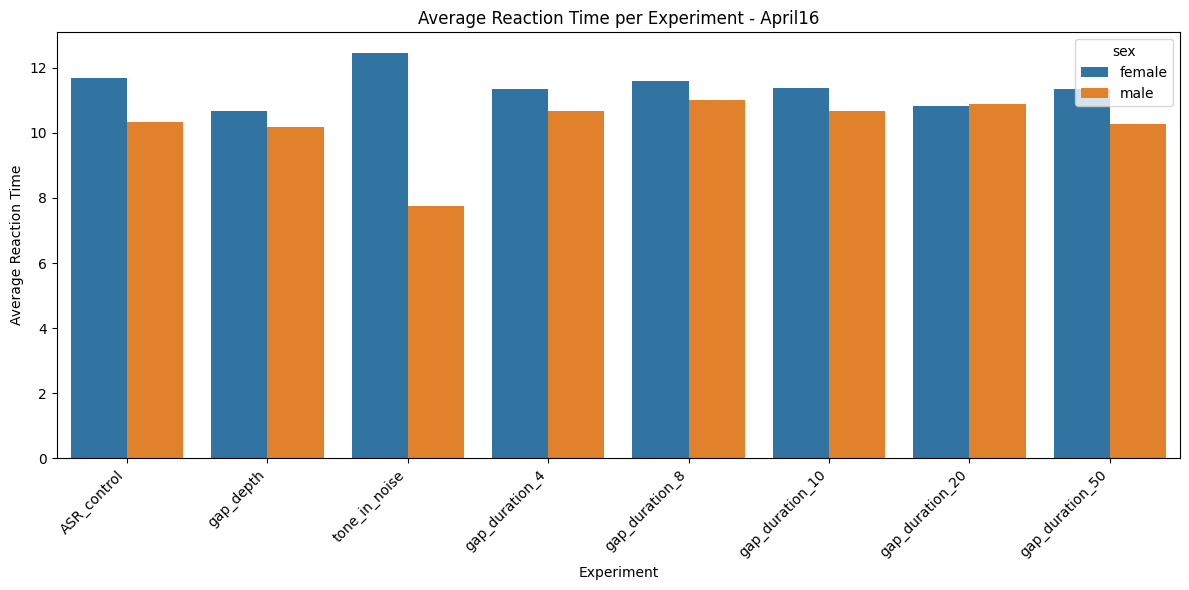

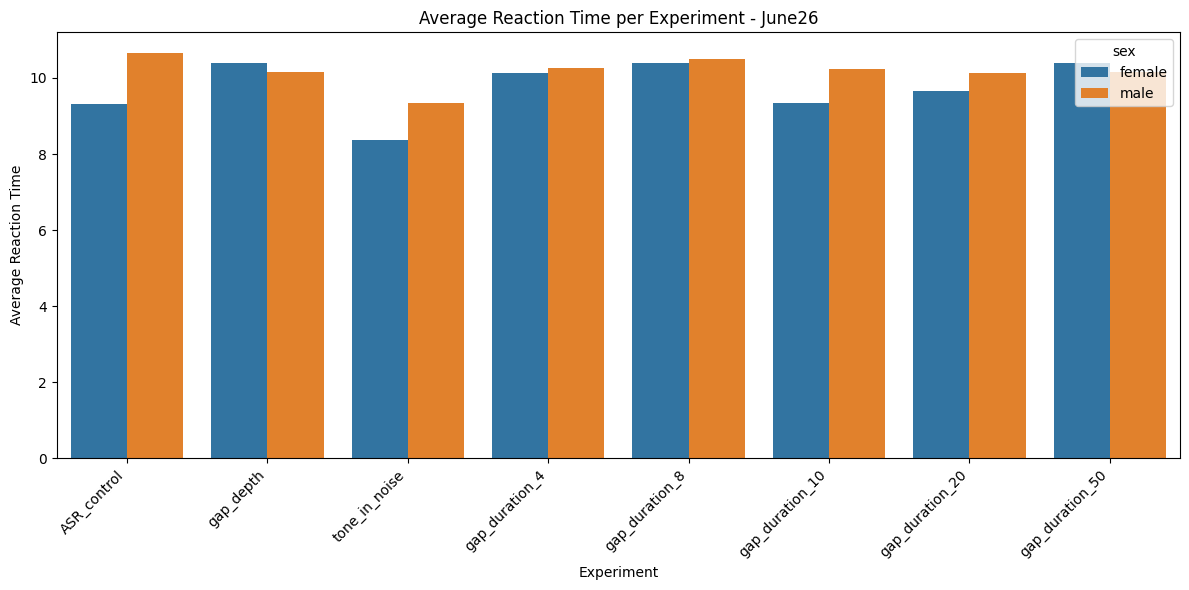

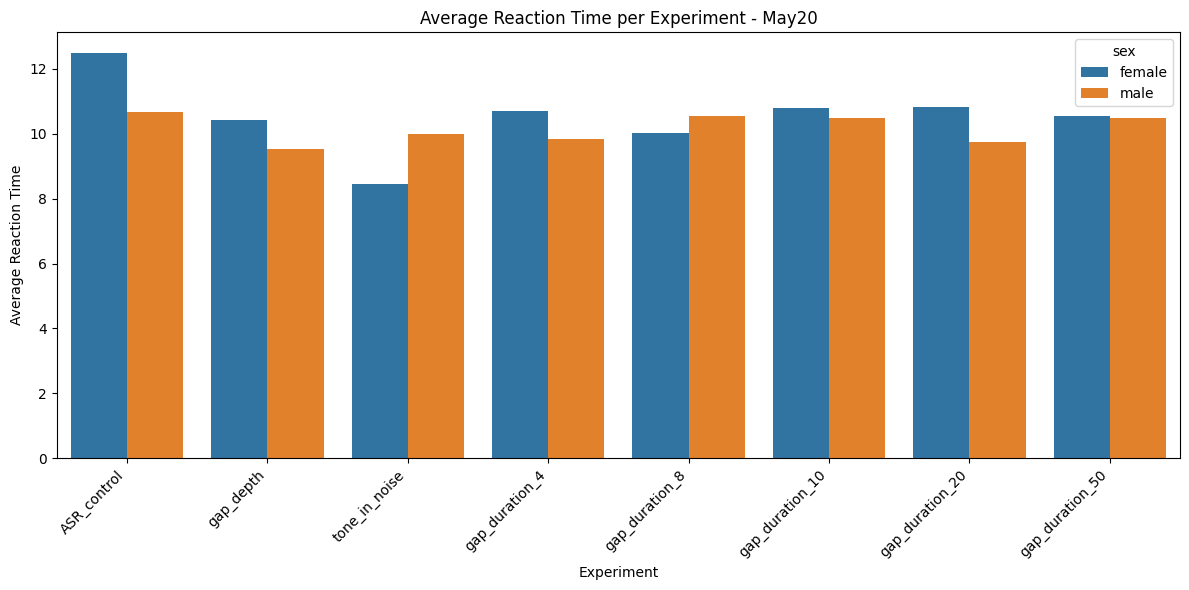

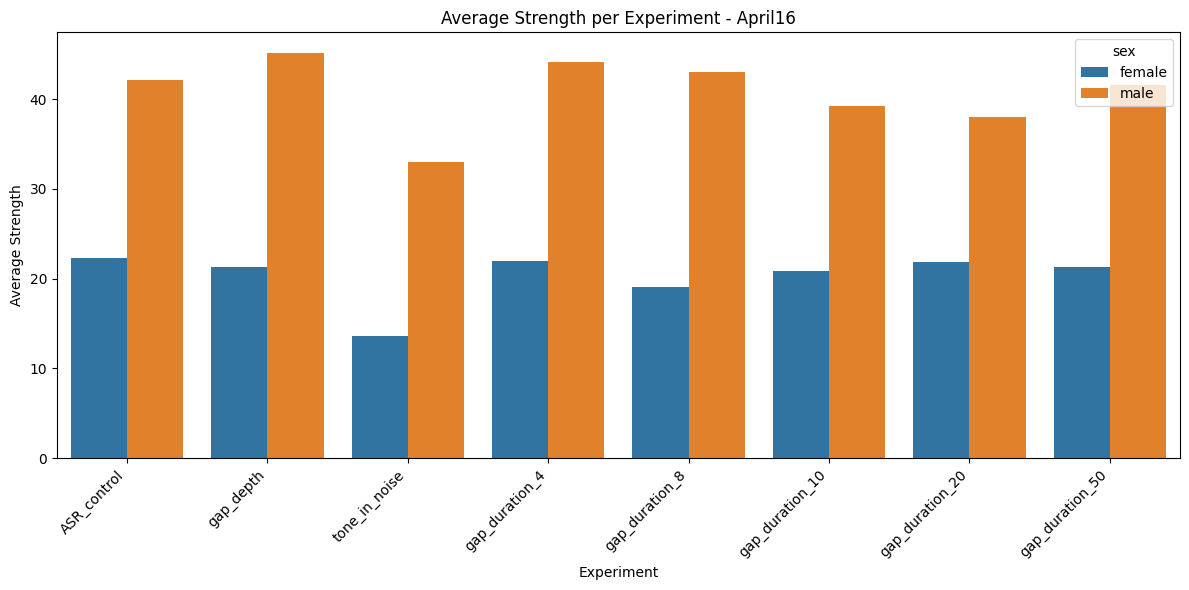

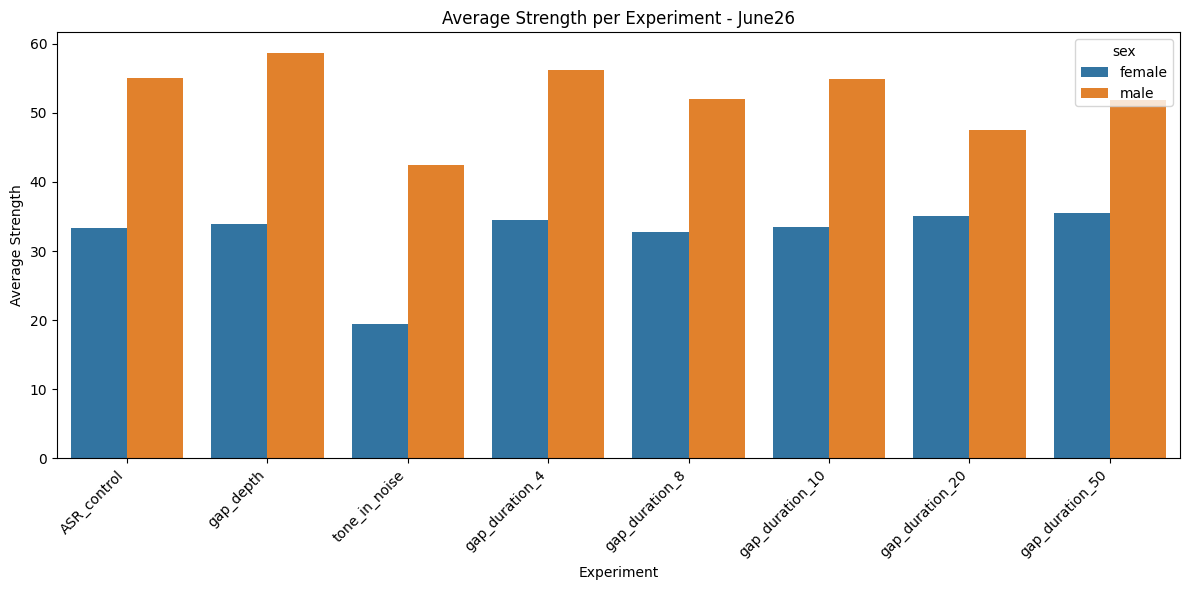

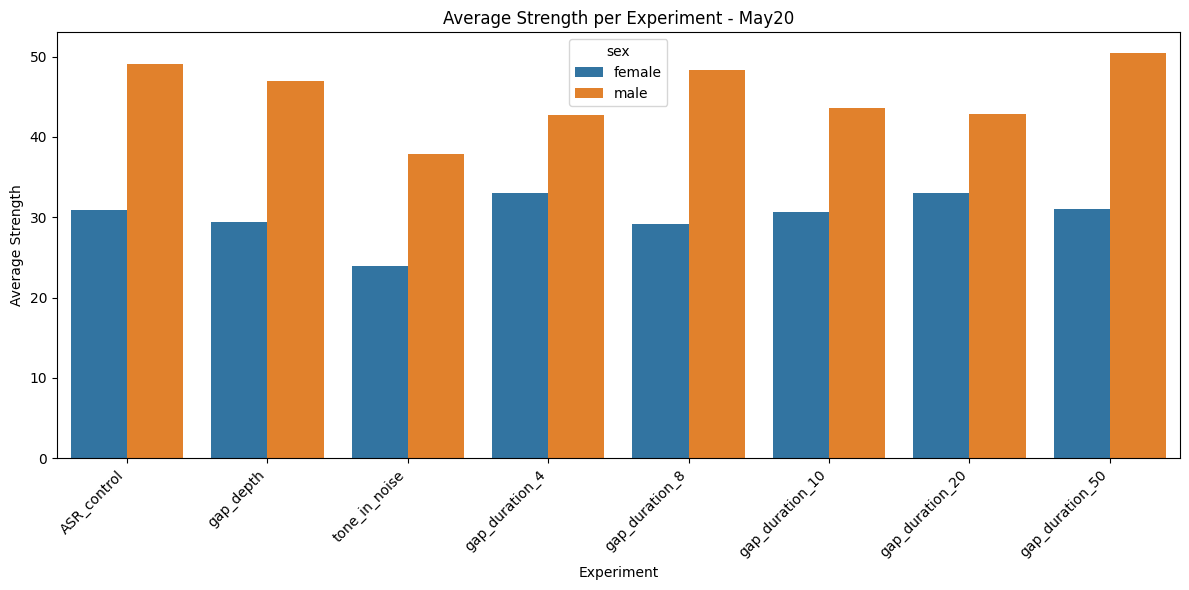

Top 10:


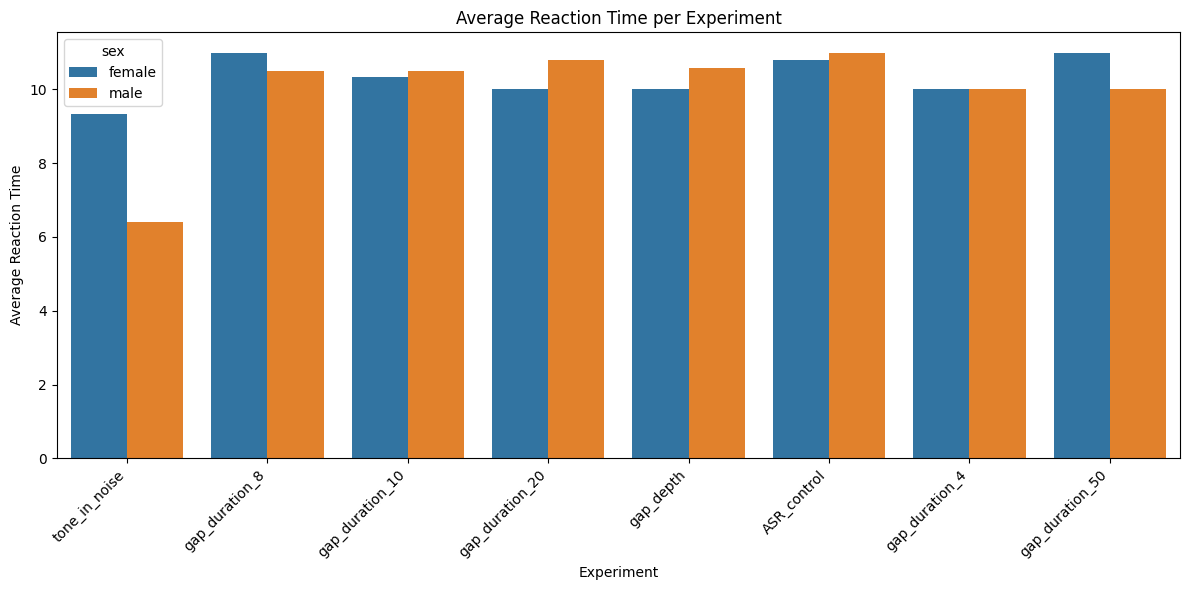

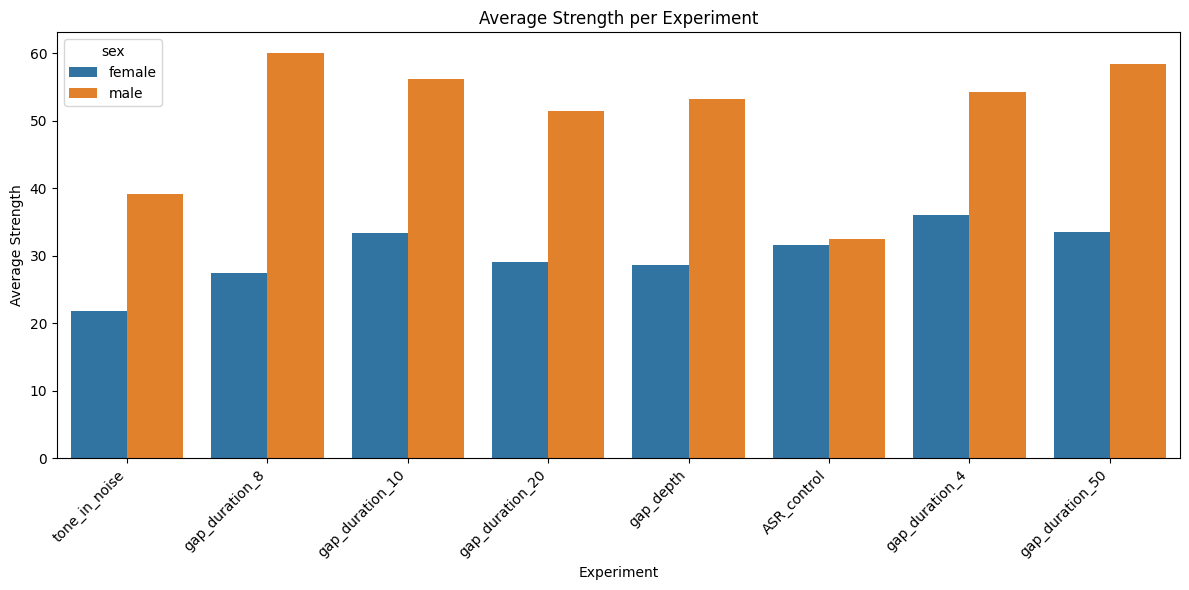

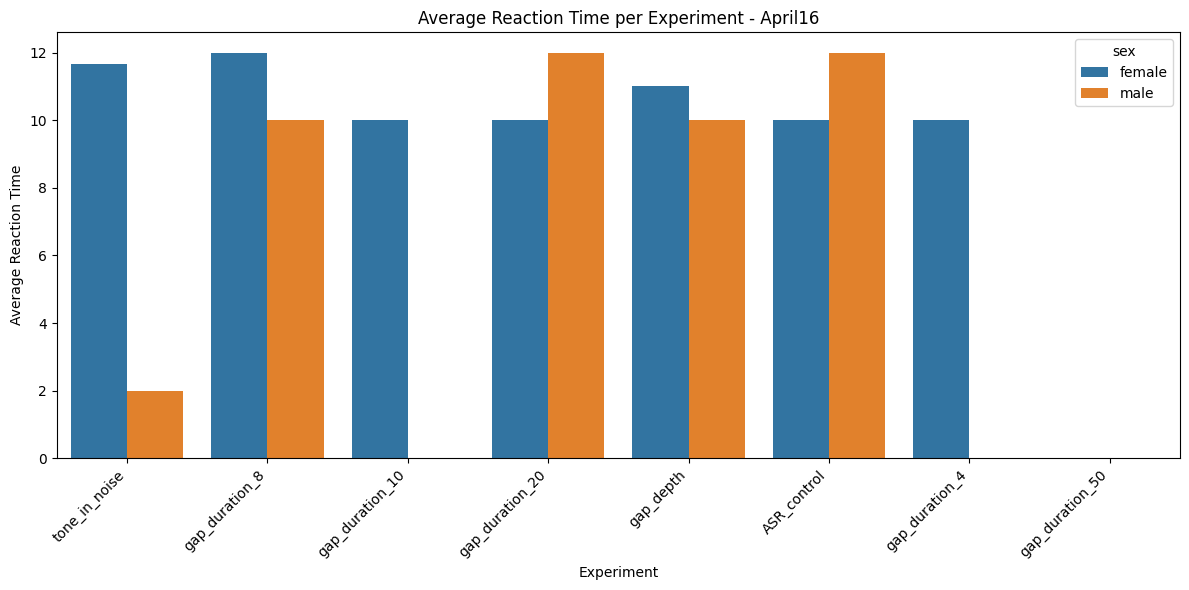

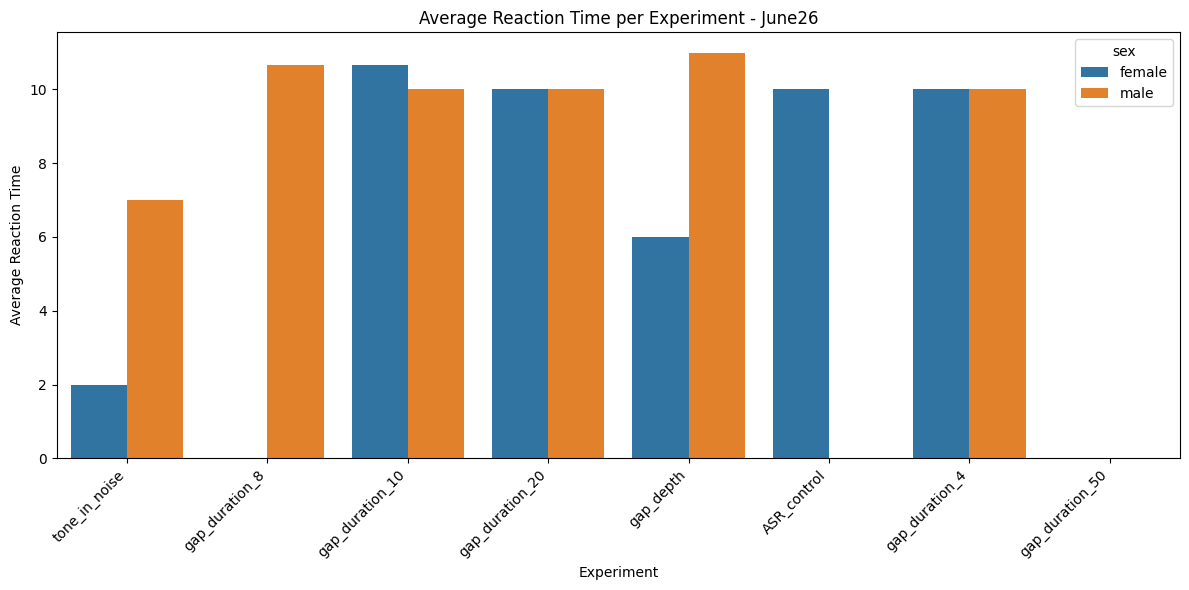

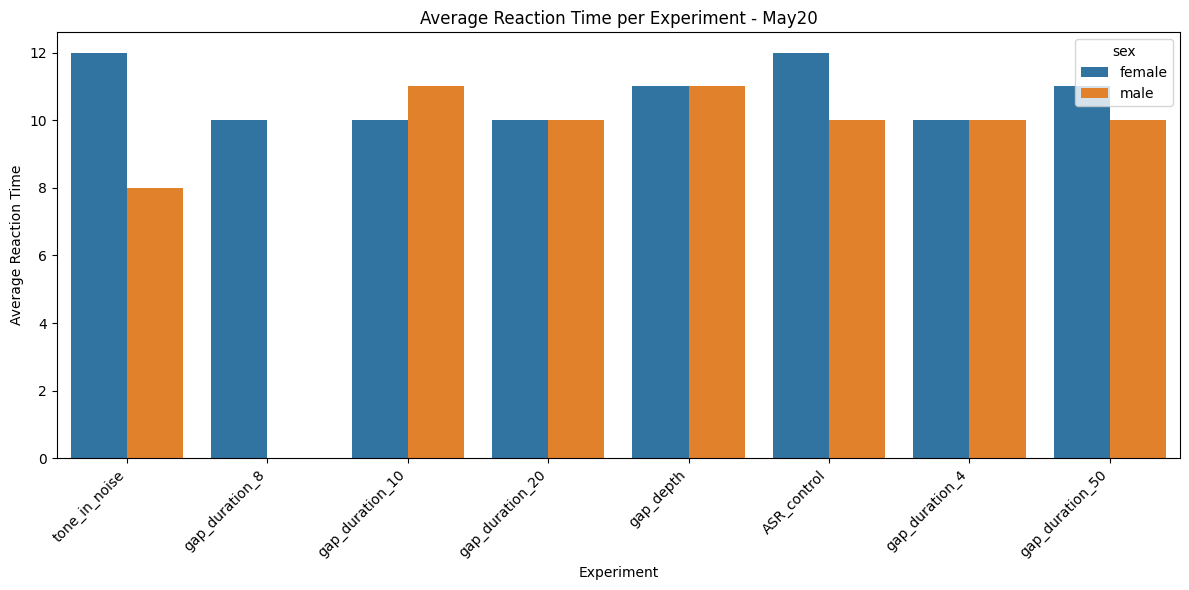

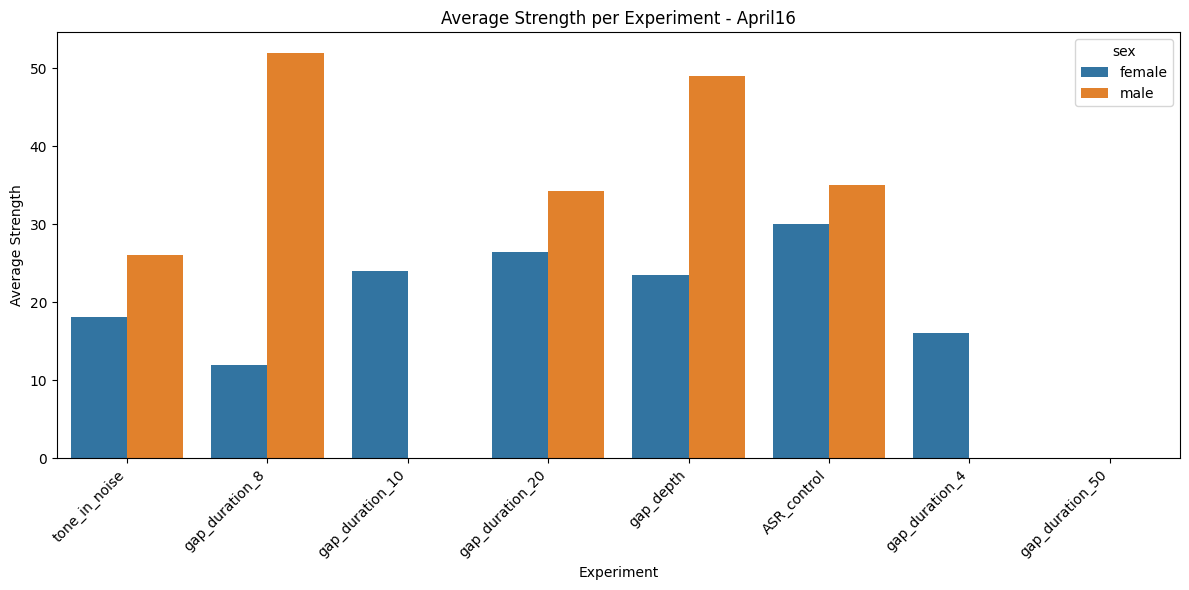

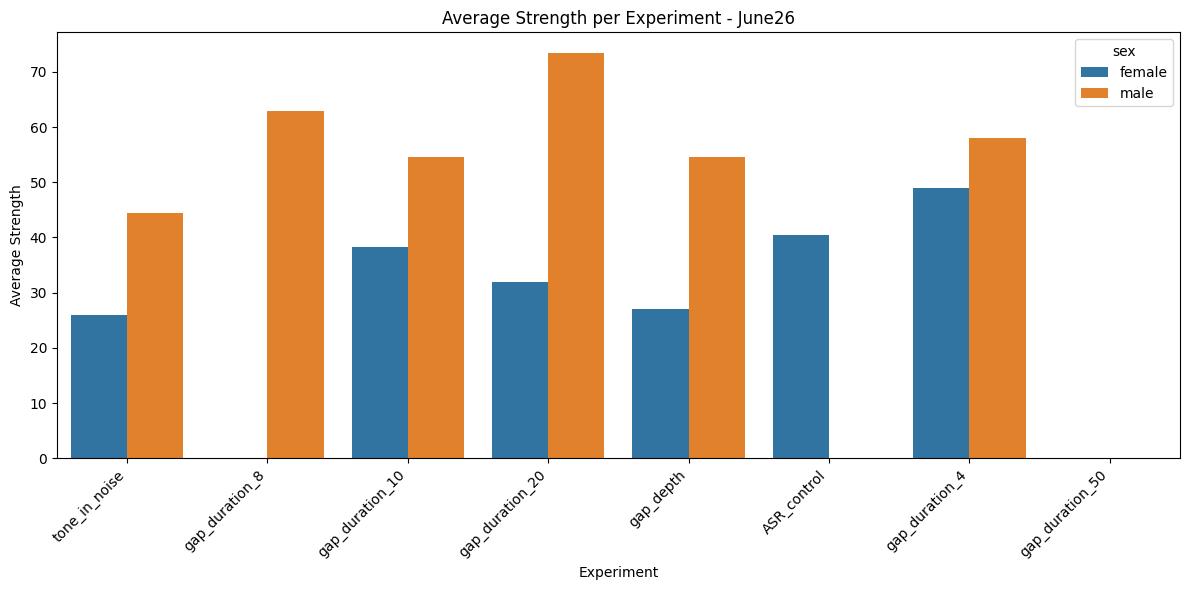

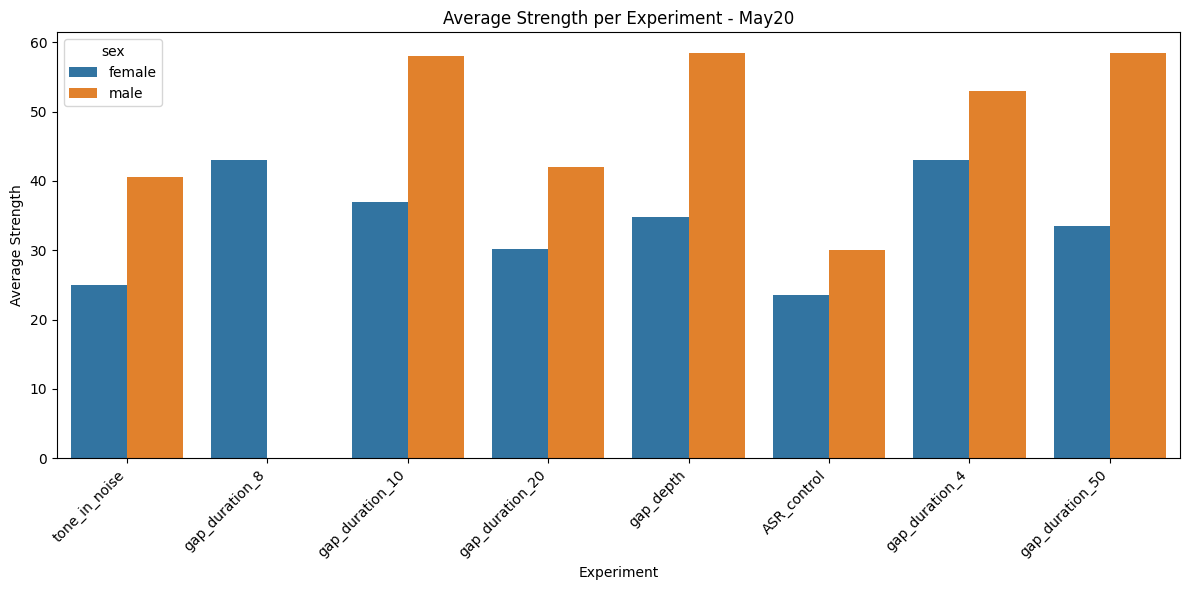

In [15]:
plot_results()
plot_results(strength=True)
plot_results(by_date=True)
plot_results(strength=True, by_date= True)

print("Top 10:")
plot_results(df=df_top_10)
plot_results(df=df_top_10, strength=True)
plot_results(df=df_top_10, by_date=True)
plot_results(df=df_top_10, strength=True, by_date= True)